In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option("display.float_format", lambda x: "%0.3f" % x)

In [3]:
data = pd.read_excel("Data/financial_loan.xlsx")
features = ["home_ownership", 
            "purpose", "annual_income", "int_rate", 
            "loan_amount", "total_acc", "loan_status"]
data = data[features]
data.rename(columns= {"annual_income": "Montly income (RUB)"}, inplace= True)
data.rename(columns={"loan_amount": "loan_amount (RUB)"}, inplace= True)
data.rename(columns= {"total_acc": "other loans"}, inplace=True)
data.rename(columns= {"loan_status": "is_loss"}, inplace= True)
data

,home_ownership,purpose,Montly income (RUB),int_rate,loan_amount (RUB),other loans,is_loss
0,RENT,car,30000.000,0.153,2500,4,Charged Off
1,RENT,car,48000.000,0.186,3000,4,Fully Paid
2,RENT,car,50000.000,0.160,12000,11,Charged Off
3,MORTGAGE,car,42000.000,0.106,4500,9,Fully Paid
4,MORTGAGE,car,83000.000,0.060,3500,28,Fully Paid
...,...,...,...,...,...,...,...
38571,MORTGAGE,wedding,100000.000,0.130,24250,33,Current
38572,RENT,wedding,50000.000,0.135,25200,18,Current
38573,RENT,wedding,65000.000,0.175,25000,20,Current
38574,RENT,wedding,368000.000,0.182,24000,9,Current


Подготавливаем числовые данные

In [54]:
dollar_to_rub = 80
#Преобразуем ежегодный доход в США в ежемесячный в России
annual_income_diff = 5.26
data["Montly income (RUB)"] = data["Montly income (RUB)"].apply(
    lambda salary: salary / annual_income_diff / 12 * dollar_to_rub).astype(int)
data["loan_amount (RUB)"] = data["loan_amount (RUB)"].apply(lambda val: val * dollar_to_rub)

Подготавливаем категориальные данные

In [ ]:
#Преобразуем статус кредита в двоичный вид
data["is_loss"] = data["is_loss"].map({"Fully Paid": 0, "Charged Off": 1, "Current": 0})

#Сокращаем кол-во категорий для целей кредита
purpose_categories = ["Debt consolidation", "credit card", "small business", "major purchase", "vacation",
                     "house",  "car"]
data["purpose"] = data["purpose"].apply(lambda purpose: purpose if purpose in purpose_categories else "other")

#Превращаем все признаки в отдельные столбцы (One-Hot encoding)
def get_custom_dummies(column: str):
    global data
    processed_cols = pd.get_dummies(data[column])
    data = pd.concat([data, processed_cols], axis = 1)
    data.drop(column, inplace= True, axis= 1)
    for column in processed_cols.columns:
        data[column] = data[column].apply(lambda val: 1 if val else 0)

#Для статуса владения жильем
get_custom_dummies("home_ownership")
drop_indexes = data[data["NONE"] == 1].index
data.drop(drop_indexes, inplace= True)
data.drop("NONE", inplace= True, axis = 1)

#Для цели кредита
get_custom_dummies("purpose")

In [56]:
data["Montly income (RUB)"].isna()
# data

0        False
1        False
2        False
3        False
4        False
         ...  
38571    False
38572    False
38573    False
38574    False
38575    False
Name: Montly income (RUB), Length: 38573, dtype: bool

Отображаем матрицу корреляции

<Axes: >

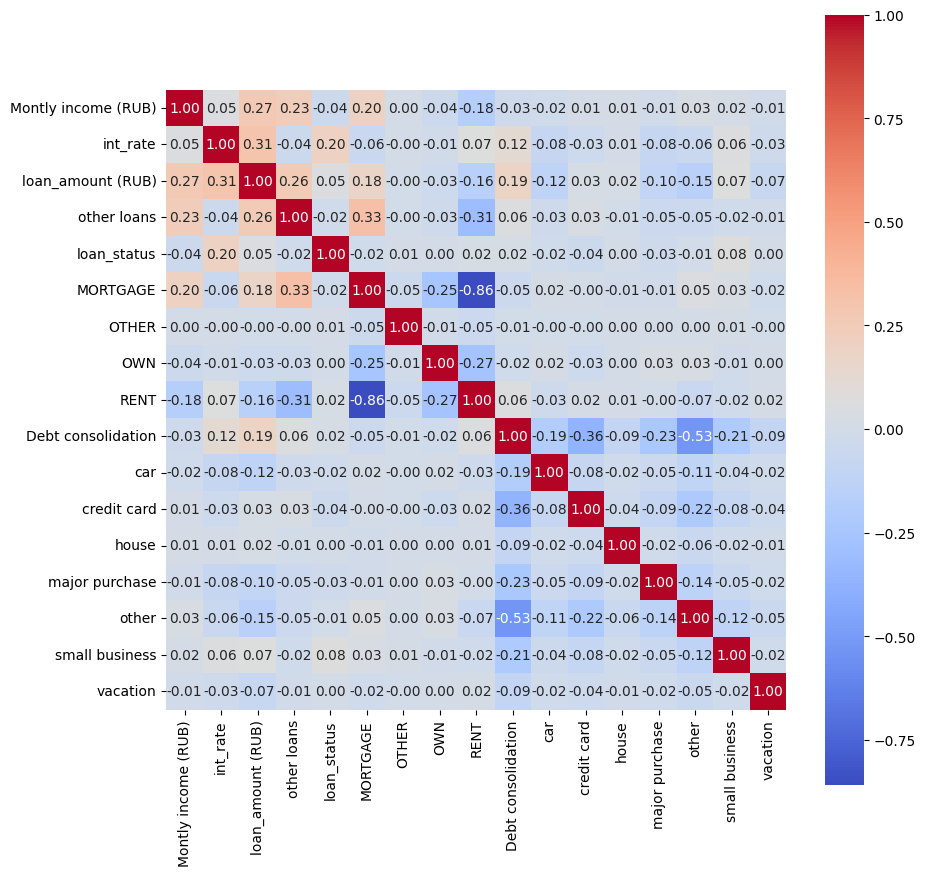

In [57]:
plt.figure(figsize=(10, 10))
sns.heatmap(data.corr(), cmap="coolwarm", annot= True, fmt=".2f", square=True)

Записываем итоговый Датасет в специальный файл

In [58]:
data.reset_index(inplace=True, drop=True)
data.to_csv("Data/processed_data", index= False)

In [61]:
data.describe()

,Montly income (RUB),int_rate,loan_amount (RUB),other loans,loan_status,MORTGAGE,OTHER,OWN,RENT,Debt consolidation,car,credit card,house,major purchase,other,small business,vacation
count,38573.000,38573.000,38573.000,38573.000,38573.000,38573.000,38573.000,38573.000,38573.000,38573.000,38573.000,38573.000,38573.000,38573.000,38573.000,38573.000,38573.000
mean,88267.793,0.120,903720.789,22.133,0.138,0.446,0.003,0.074,0.478,0.472,0.039,0.130,0.009,0.055,0.240,0.046,0.009
std,81489.269,0.037,596865.226,11.392,0.345,0.497,0.050,0.261,0.500,0.499,0.193,0.336,0.097,0.227,0.427,0.210,0.095
min,5069.000,0.054,40000.000,2.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,52598.000,0.093,440000.000,14.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,76045.000,0.119,800000.000,20.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
75%,105449.000,0.146,1200000.000,29.000,0.000,1.000,0.000,0.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
max,7604562.000,0.246,2800000.000,90.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
